<a href="https://colab.research.google.com/github/cammaral/tn-for-cfd/blob/main/burguer_2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install quimb

In [ ]:
import numpy as np
import quimb as qu
import matplotlib.pyplot as plt
import sys
import quimb.tensor as qtn
import time

# 1. Finite Difference Method
## Spatial and temporal discretization
Let's consider the one-dimensional viscous Burgers equation,
\begin{equation}
    \frac{\partial u(x,t)}{\partial t} = -u(x,t)\frac{\partial u(x,t)}{\partial x} + \nu \frac{\partial^2 u(x,t)}{\partial x^2},
\end{equation}
where $u(x,t)$ is a scalar velocity field and $\nu$ is the kinematic viscosity.

The domain is periodic, with initial condition $u(x,0) = \sin{(2\pi x)}$, defined on $x \in [0,1]$ and time interval $t \in [0,T]$.

First, our goal is solve this equation using Euler Explicit Method
With a discretized time step $\Delta t$, the update rule is,

\begin{equation}
    u_{t+1} = u_t + \Delta t\, \mathcal{L}(u_t),
\end{equation}

where the spatial operator $\mathcal{L}$ incorporates both nonlinear advection and diffusion,
\begin{equation}
    \mathcal{L}(u_t) = -u_t \cdot \frac{\partial u_t}{\partial x} + \nu \frac{\partial^2 u_t}{\partial x^2}.
\end{equation}

For space, we will discretize it into $N = 2^n$ parts equally spaced ($\Delta x$).

In [ ]:
#========================
# PARAMETERS
#========================

nu = 0.01

L = 1.0
n = 9
N = 2**n
dx = L / (N - 1)
x = np.linspace(0, L, N)

T = 0.1
dt = 0.0001
t = np.arange(0, T + dt, dt)

#========================
# INITIAL u(x,0)
#========================
u0 = np.sin(2 * np.pi * x)

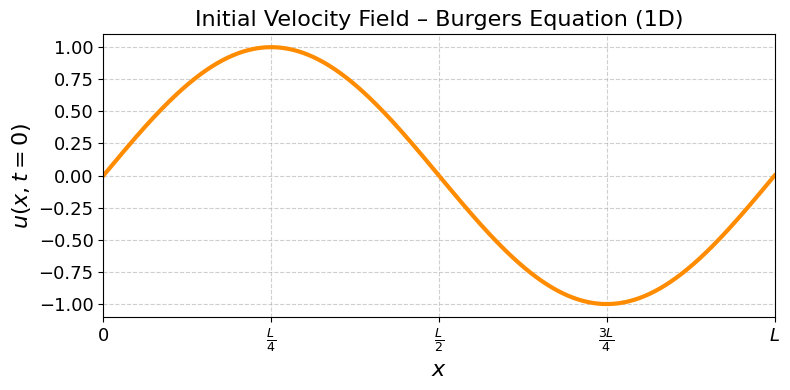

In [ ]:
#========================
# PLOT - u(x,0)
#========================

tick_positions = np.linspace(0, L, 5)
tick_labels = [r"$0$", r"$\frac{L}{4}$", r"$\frac{L}{2}$", r"$\frac{3L}{4}$", r"$L$"]

plt.figure(figsize=(8, 4))
plt.plot(x, u0, lw=3, c='darkorange')
plt.xlim(0, L)
plt.ylim(-1.1, 1.1)

plt.xlabel(r'$x$', fontsize=16)
plt.ylabel(r'$u(x, t=0)$', fontsize=16)
plt.title('Initial Velocity Field – Burgers Equation (1D)', fontsize=16)

plt.xticks(tick_positions, tick_labels, fontsize=13)
plt.yticks(fontsize=13)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## Spatial Derivative in FDM
Using the spatial operator $\mathcal{L}$ in Finite Diference Method (FDM), also requires discretizing the differential operators.

For the first-order derivative (advection term), we use the centered scheme,
\begin{equation}
    \frac{\partial u_i}{\partial x} \approx \frac{u_{i+1} - u_{i-1}}{2\Delta x},
\end{equation}
which leads to the first-derivative matrix $D^{(1)} \in \mathbb{R}^{N \times N}$ with periodic boundary conditions,
\begin{equation}
    D^{(1)} = \frac{1}{2\Delta x}
    \begin{bmatrix}
    0 & 1 & 0 & \cdots & 0 & -1 \\
    -1 & 0 & 1 & \cdots & 0 & 0 \\
    0 & -1 & 0 & \cdots & 0 & 0 \\
    \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
    0 & 0 & 0 & \cdots & 0 & 1 \\
    1 & 0 & 0 & \cdots & -1 & 0
    \end{bmatrix},
\end{equation}
while, for the second-order derivative (diffusion term), we adopt the second-order centered finite difference,
\begin{equation}
    \frac{\partial^2 u_i}{\partial x^2} \approx \frac{u_{i-1} - 2u_i + u_{i+1}}{(\Delta x)^2},
\end{equation}
where the subscript $i$ refers to the discrete spatial index. This leads to the discrete Laplacian operator, represented by a circulant matrix $D ^{(2)}\in \mathbb{R}^{N \times N}$,
\begin{equation}
     D ^{(2)} = \frac{1}{(\Delta x)^2}
    \begin{bmatrix}
    -2 & 1 & 0 & \cdots & 0 & 1 \\
    1 & -2 & 1 & \cdots & 0 & 0 \\
    0 & 1 & -2 & \cdots & 0 & 0 \\
    \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
    0 & 0 & 0 & \cdots & -2 & 1 \\
    1 & 0 & 0 & \cdots & 1 & -2
    \end{bmatrix}.
\end{equation}

In [ ]:
#========================
# DIFFERENTIAL OPERATORS
#========================

D1 = np.zeros((N, N))
for i in range(N):
    D1[i, (i - 1) % N] = -1 / (2 * dx)
    D1[i, (i + 1) % N] =  1 / (2 * dx)

D2 = np.zeros((N, N))
for i in range(N):
    D2[i, i] = -2 / (dx ** 2)
    D2[i, (i - 1) % N] = 1 / (dx ** 2)
    D2[i, (i + 1) % N] = 1 / (dx ** 2)


## Time Evolution
With the discretized evolution, now we now perform the time evolution using the Euler method. The state $u_t$, is updated iteratively by computing the action of the operator $\mathcal{L}$ in $u_t$.

An important step is how evaluate the nonlinear advection term $u \cdot \partial_x u$, in the discrete space. For this, we use the Hadamard (element-wise) product between $\textbf{u}$ and $D^{(1)} \textbf{u}$,

\begin{equation}
    \left[\textbf{u} \cdot \frac{\partial \textbf{u}}{\partial x} \right]_i \approx u_i \cdot (D^{(1)} \textbf{u})_i.
\end{equation}

Once $u$ is given in an array, one can just use the "*" operation.

In [ ]:
#========================
# TEMPORAL EVOLUTION
#========================

Nt = len(t) # number of steps

u = u0.copy()
for step in range(Nt):
    dudx = D1 @ u
    d2udx2 = D2 @ u
    convection = u * dudx  # Hadamard Product
    diffusion = nu * d2udx2
    u = u + dt * (-convection + diffusion) # New ut

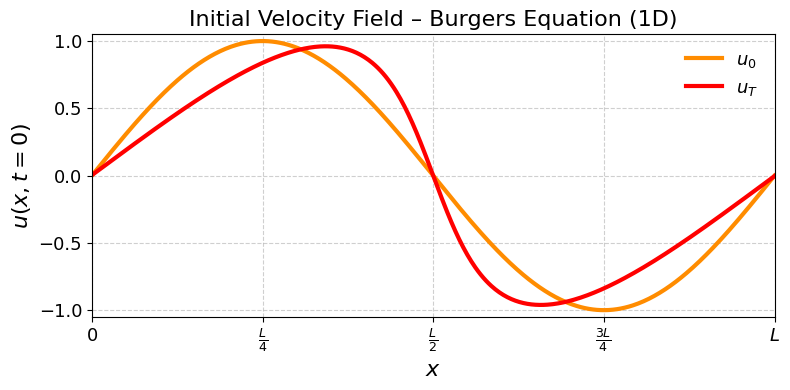

In [ ]:
#========================
# PLOT - u(x,0) and u(x,T)
#========================

tick_positions = np.linspace(0, L, 5)
tick_labels = [r"$0$", r"$\frac{L}{4}$", r"$\frac{L}{2}$", r"$\frac{3L}{4}$", r"$L$"]

plt.figure(figsize=(8, 4))
plt.plot(x, u0, lw=3, c='darkorange', label='$u_0$')
plt.plot(x, u, lw=3, c='red', label='$u_T$')

plt.xlim(0, L)
plt.ylim(-1.05, 1.05)

plt.xlabel(r'$x$', fontsize=16)
plt.ylabel(r'$u(x, t=0)$', fontsize=16)
plt.title('Initial Velocity Field – Burgers Equation (1D)', fontsize=16)

plt.xticks(tick_positions, tick_labels, fontsize=13)
plt.yticks(np.linspace(-1, 1, 5),fontsize=13)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=13, frameon=False)
plt.tight_layout()
plt.show()


# 2. Tensor Network framework

To solve the same problem using TN, we need follow the four steps:

(1) **Discretization** $→$ (2) **Tensorization** $→$ (3) **Temporal Evolution** $→$ (4) **Extacting Information**

The first step has already been completed at the beginning of Section 1. Here, we start with step (2) Tensorization.

## 2.1 Step 2: Tensorization
### 2.1.1 Initial Vector

Now we reshape the vector $\mathbf{u}$ into a high-order tensor $\mathcal{U}_{i_1i_2\ldots i_L} \in \mathbb{R}^{2\times2\times \cdots\times 2}$ with $L$ indices, where each $i_k \in \{0,1\}$.

 The utilization of each element of the tensor with $\mathbb{R}^{2}$ is intended to enable the binary representation of the mesh points for mapping to quantum states using this binary encoding. In this context, note that each element of $\mathbf{u}$, indexed by an integer $j \in [0, N-1]$, has a binary representation of length $L$, $j=(i_1, i_2, \ldots, i_L)_2$.

Then,
\begin{equation}
    \mathcal{U}_{i_1 i_2 \ldots i_L} := u_j = u_{(i_1 i_2 \ldots i_L)_2}.
\end{equation}

With this, we can apply the SVD techinique to obtain the MPS representation. Fortunately, **Quimb** do it directly using the function **MatrixProductState.from_dense(...)**. The given parameters are,

- **`cutoff`**: defines the truncation threshold $\varepsilon$ for discarding singular values $\lambda_i < \varepsilon$ during SVD. Controls numerical precision and compression.

- **`chi`**: sets the maximum bond dimension $\chi$ allowed in the MPS. A larger $\chi$ improves expressiveness but increases cost.

- **`site_ind_id = 'k{}'`**: defines the naming pattern for physical indices. For site $i$, the index is labeled $k_i$.

- **`site_tag_id = 's{}'`**: assigns a tag to each tensor in the MPS for tracking or visualization. For site $i$, the tag is $s_i$.

In [ ]:
#========================
# TENSORIZATION - u(x,0)
#========================

cutoff = 1e-40
chi = 4
site_ind_id='k{}'
site_tag_id='s{}'

u0_tensor = u0.reshape([2]*(n))
u0_mps = qtn.MatrixProductState.from_dense(u0_tensor,
                                           cutoff=cutoff,
                                           max_bond=chi,
                                           site_ind_id=site_ind_id,
                                           site_tag_id=site_tag_id)

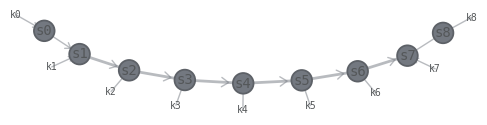

MatrixProductState(tensors=9, indices=17, L=9, max_bond=4)

In [ ]:
u0_mps.draw()
u0_mps

### 2.1.2 Differential Operator

We can define the first derivative operator using local two-site terms as
\begin{equation}
  D^{(1)} = \sum_{i=1}^{L} \hat{h}^{(1)}_{i,i+1}, \quad \text{where} \quad \hat{h}^{(1)} = T^- \otimes T^+ - T^+ \otimes T^-,
\end{equation}
with $T^+ = |0\rangle \langle 1 |$ and $T^- = |1\rangle \langle 0 |$. Each $\hat{h}^{(1)}_{i,i+1}$ acts only on neighboring sites $(i, i+1)$, with identities acting elsewhere.

Due to the rapid growth of the bond dimension when applying a tensor sum, this process can be computationally costly. Then we construct explicity the global MPO $T_p$, which is constructed to apply a global right-cyclic shift:

\begin{equation}
  T^+ |i_1 i_2 \dots i_L\rangle = |i_L i_1 \dots i_{L-1}\rangle.
\end{equation}

From this, the derivative operator is approximated using the MPOs as:
\begin{equation}
  D^{(1)} \approx \frac{T_m - T_p}{2\Delta x},
\end{equation}
where $T_m$ is obtained as the Hermitian conjugate of $T_p$, followed by a partial transpose on the physical indices. For the second-order derivative operator, we have in the MPO representation:
\begin{equation}
  D^{(2)} \approx \frac{T_p + T_m - 2I}{\Delta x^2},
\end{equation}
where $I$ is the identity MPO.


Therefore, the expressions $(T_m - T_p) / (2\Delta x)$ and $(T_p + T_m - 2I) / \Delta x^2$ effectively includes the entire sum $\sum_i \hat{h}^{(1)}_{i,i+1}$ and $\sum_i \hat{h}^{(2)}_{i,i+1}$, respectively, with periodic boundary conditions.



### Construction of the Right-Shift Operator  $T^+$ as an MPO

We denote the MPO representation of the right-shift operator by $T_p$. It is given by:
\begin{equation}
  T_p = \sum_{\{d_k, u_k\}} \mathrm{Tr} \left[ W^{[1]}_{d_1, u_1} W^{[2]}_{d_2, u_2} \cdots W^{[L]}_{d_L, u_L} \right] |d_1 d_2 \cdots d_L\rangle \langle u_1 u_2 \cdots u_L|,
\end{equation}

where the operator $T_p$ implements the same action as the abstract right-cyclic shift operator $T^+$.

To construct $T_p$, we need define three kinds of tensors:

#### Left-end tensor $W^{[1]}$

$$
W^{[1]} \in \mathbb{R}^{2 \times 1 \times 2 \times 2}
$$

with entries:

- $W^{[1]}_{0,0,0} = 1$ &nbsp; (copy $|0\rangle$ if no bit arrives)
- $W^{[1]}_{1,1,0} = 1$ &nbsp; (copy $|1\rangle$)
- $W^{[1]}_{0,1,1} = 1$ &nbsp; ($|1\rangle$ arrives, produce $|1\rangle$)
- $W^{[1]}_{1,0,1} = 1$ &nbsp; ($|0\rangle$ arrives, erase $|1\rangle$)

#### Bulk tensor $W^{[k]}$, $2 \leq k \leq L-1$

$$
W^{[k]} \in \mathbb{R}^{2 \times 2 \times 2 \times 2}
$$

with non-zero entries:

- $W^{[k]}_{0,0,0,0} = 1 $ &nbsp; (keep $|0\rangle$ if R = 0)
- $W^{[k]}_{1,0,1,0} = 1 $ &nbsp; (keep $|1\rangle$)
- $W^{[k]}_{1,1,0,1} = 1 $ &nbsp; (R = 1, send $|0\rangle$)
- $W^{[k]}_{0,0,1,1} = 1 $ &nbsp; (R = 1, send $|1\rangle$)

#### Right-end tensor $W^{[L]}$

$$
W^{[L]} = \text{contract}(\text{vec}([0, 1]) \otimes W^{\text{bulk}}) \in \mathbb{R}^{2 \times 2 \times 2 \times 1}
$$

This emits a virtual "bit" to the left, completing the cyclic shift by wrapping around the last bit to the first site.



### Interpretation

The right-shift operator $T^+$ is thus realized by propagating a virtual excitation (representing a bit) from right to left across the MPO network. The transformation is encoded in the tensor contractions across the virtual bonds.

This MPO representation has bond dimension 2 and exactly encodes the full cyclic shift operator:

$$
T^+ = \sum_{i=1}^L \hat{I}_1 \otimes \cdots \otimes \hat{T}_{i,i+1}^{(+)} \otimes \cdots \otimes \hat{I}_L,
$$

where the local effect is distributed across the MPO without needing to sum separate two-site terms.


In [ ]:
# Number of tensors in the initial MPS
num_ten = u0_mps.L

# Index identifiers for site and physical indices (used by quimb)
siteTagId = 's{}'
upIndIds = "k{}"
downIndIds = "b{}"

# =======================
# Left-end tensor construction
# =======================

# Shape: (D, U, R) → input, output, right bond
left_array = np.zeros((2, 2, 2))

# R = 0: copy the value
left_array[0, 0, 0] = 1.0
left_array[1, 1, 0] = 1.0

# R = 1: propagate the bit
left_array[0, 1, 1] = 1.0
left_array[1, 0, 1] = 1.0

# =======================
# Bulk tensor construction
# =======================

# Shape: (D, L, U, R)
bulk_array = np.zeros((2, 2, 2, 2))

# R = 0: copy
bulk_array[0, 0, 0, 0] = 1.0
bulk_array[1, 0, 1, 0] = 1.0

# R = 1: propagate
bulk_array[1, 1, 0, 1] = 1.0
bulk_array[0, 0, 1, 1] = 1.0

# =======================
# Right-end tensor (initiates the shift)
# =======================

# Bit emitted to the left (0 or 1)
right_array = np.array([0.0, 1.0])

# =======================
# Identity tensor for padding (unused here)
# =======================

id_array_chi1 = np.zeros((2, 2))
id_array_chi1[0, 0] = 1.0
id_array_chi1[1, 1] = 1.0

# =======================
# Convert arrays to quimb tensors
# =======================

bulk_tensor = qu.tensor.Tensor(
    data=bulk_array.reshape(2, 2, 2, 2, order='F'),
    inds=['D', 'L', 'U', 'R']
)

left_tensor = qu.tensor.Tensor(
    data=left_array.reshape(2, 1, 2, 2, order='F'),
    inds=['D', 'L', 'U', 'R']
)

right_tensor = qu.tensor.Tensor(
    data=right_array.reshape(2, 1, order='F'),
    inds=['R', 'dummy']
)
right_tensor = (right_tensor & bulk_tensor)^...
right_tensor = qu.tensor.Tensor(
    data=right_tensor.data.reshape(2, 2, 2, 1),
    inds=['D', 'L', 'U', 'R']
)

# Remove unnecessary singleton dimensions
left_tensor.squeeze(inplace=True)
right_tensor.squeeze(inplace=True)

# Identity tensors for potential padding
idLeft_tensor = qu.tensor.Tensor(
    data=id_array_chi1.reshape(2, 2, 1, order='F'),
    inds=['D', 'U', 'R']
)

idRight_tensor = qu.tensor.Tensor(
    data=id_array_chi1.reshape(2, 1, 2, order='F'),
    inds=['D', 'L', 'U']
)

idBulkChi1_tensor = qu.tensor.Tensor(
    data=id_array_chi1.reshape(2, 1, 2, 1, order='F'),
    inds=['D', 'L', 'U', 'R']
)

# =======================
# Final MPO tensor list
# =======================

arrays = [left_tensor.data] + [bulk_tensor.data] * (num_ten - 2) + [right_tensor.data]

# =======================
# Build the final MPO object
# =======================
Tp = qu.tensor.tensor_1d.MatrixProductOperator(
    arrays=arrays,
    shape='dlur',
    site_tag_id=siteTagId,
    upper_ind_id=upIndIds,
    lower_ind_id=downIndIds
)


Although this structure may seem strange, when we return this MPO to the dense presentation, we can see how part of the matrix representing the derivative begins to emerge here.

In [ ]:
Tp.to_dense()

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

To obtain $T^-$, we simply obtain the Hermitian conjugate of $T^+$. Also, we need obtain the identity as MPO.



In [ ]:
# =======================
# Final MPO tensor list
# =======================
Tm = Tp.H.partial_transpose(list(range(N)), inplace=False)
Id = Tp.identity()


In [ ]:
# =======================
# Parameters for Compression
# =======================
COMP_OPTS = {
    "compress": True,
    "cutoff_mode": 'rel',
    "cutoff": cutoff
}


# =======================
# First-order derivative MPO
# =======================
zero = 1e-40
D1_mpo = Id.multiply(zero, inplace=False)
D1_mpo.add_MPO((-1 / (2 * dx)) * Tp, inplace=True, **COMP_OPTS)
D1_mpo.add_MPO((+1 / (2 * dx)) * Tm, inplace=True, **COMP_OPTS)


# =======================
# Second-order derivative MPO
# =======================
D2_mpo = Id.multiply(-2 / (dx**2), inplace=False)
D2_mpo.add_MPO((+1 / (dx**2)) * Tp, inplace=True, **COMP_OPTS)
D2_mpo.add_MPO((+1 / (dx**2)) * Tm, inplace=True, **COMP_OPTS)


MatrixProductOperator(tensors=9, indices=26, L=9, max_bond=5)

Passing these MPOs to dense vectors, we can see that they are indeed what we expected.

In [ ]:
D1_mpo.to_dense(), D2_mpo.to_dense()

(array([[ 4.84401617e-30,  2.55500000e+02, -8.34132237e-32, ...,
         -9.72499490e-14,  9.92532238e-31, -2.55500000e+02],
        [-2.55500000e+02, -7.54317621e-25,  2.55500000e+02, ...,
          9.38434443e-40, -2.95842398e-13,  1.50863524e-24],
        [ 8.25705790e-31, -2.55500000e+02,  4.96198028e-30, ...,
         -2.43175332e-13, -2.83661983e-14, -8.26482078e-14],
        ...,
        [-5.84230831e-14,  4.27833885e-40, -6.99680649e-14, ...,
         -7.54317621e-25,  2.55500000e+02, -7.54317621e-25],
        [ 4.04298590e-46, -8.75198570e-14, -1.28335021e-28, ...,
         -2.55500000e+02, -6.63098962e-30,  2.55500000e+02],
        [ 2.55500000e+02, -7.54317621e-25, -5.12020728e-15, ...,
          1.50863524e-24, -2.55500000e+02, -7.54317621e-25]]),
 array([[-5.22242000e+05,  2.61121000e+05,  2.29966398e-12, ...,
          7.17499485e-10,  4.41629833e-12,  2.61121000e+05],
        [ 2.61121000e+05, -5.22242000e+05,  2.61121000e+05, ...,
          2.48264962e-10,  5.64952773e

# Hadamard Product via Zip-Up Contraction in Tensor Networks

Before performing the time evolution, we need to define the Hadamard product. To do this more efficiently, we use the zip-up contraction scheme, which allows us to control the bond dimension at each step.

Given:

- An MPS $$|u\rangle \in \mathbb{C}^{2^L}$$, written in tensor network form as:

$$
|u\rangle = \sum_{i_1,\ldots,i_L} A^{[1]}_{i_1} A^{[2]}_{i_2} \cdots A^{[L]}_{i_L} |i_1,\ldots,i_L\rangle
$$

- Another MPS $$|v\rangle \in \mathbb{C}^{2^L}$$, written similarly as:

$$
|v\rangle = \sum_{i_1,\ldots,i_L} B^{[1]}_{i_1} B^{[2]}_{i_2} \cdots B^{[L]}_{i_L} |i_1,\ldots,i_L\rangle
$$

We want to compute the Hadamard (elementwise) product:

$$
|w\rangle = |u\rangle \circ |v\rangle, \quad \text{with} \quad w_{i_1,\ldots,i_L} = u_{i_1,\ldots,i_L} \cdot v_{i_1,\ldots,i_L}
$$

This is achieved by:

- Constructing a diagonal MPO $\mathcal{D}_u$ from $|u\rangle$,
- Applying $\mathcal{D}_u$ to $|v\rangle$,
- Compressing the result using a zip-up contraction scheme.

## Step 1 — Building the Diagonal MPO $\mathcal{D}_u$

Each tensor of the MPS $|u\rangle$ is transformed into a diagonal operator using a copy tensor.

The copy tensor is a 3-legged object that acts like a discrete Dirac delta:

\begin{equation}
\delta_{ijk} = \delta_{ij} \delta_{jk} =
\begin{cases}
1 & \text{if } i = j = k \\
0 & \text{otherwise}
\end{cases}
\end{equation}

It ensures that the input, output, and internal index all match.

Let the local MPS tensor be $A^{[i]}_{a_{i-1}, i, a_i}$, and the copy tensor $\delta^{[i]}_{i, j, k} = \delta_{ij} \delta_{jk}$. Then the local MPO tensor is:

\begin{equation}
  M^{[i]}_{a_{i-1}, a_i}(j, k) = \sum_{i} A^{[i]}_{a_{i-1}, i, a_i} \cdot \delta_{ij} \delta_{jk} = A^{[i]}_{a_{i-1}, j, a_i} \cdot \delta_{jk}
\end{equation}

This constructs a diagonal MPO:

\begin{equation}
  \mathcal{D}_u = \sum_{i} u_{i_1,\ldots,i_L} |i_1,\ldots,i_L\rangle \langle i_1,\ldots,i_L|
\end{equation}

## Step 2 — Applying $\mathcal{D}_u$ to $|v\rangle$

We then apply the diagonal MPO to the second MPS:

\begin{equation}
  |w\rangle = \mathcal{D}_u |v\rangle = \sum_{i} u_{i} v_{i} |i\rangle = |u\rangle \circ |v\rangle
\end{equation}

This corresponds to contracting both networks site-by-site over the physical indices.

## Step 3 — Zip-Up Contraction and Compression

To maintain efficiency and avoid exponential bond dimension growth, a zip-up contraction strategy is used.

The zip-up steps are as follows:

- Contract the first site manually and perform SVD:

$$
T_0 \rightarrow U_0 \cdot S_0 \cdot V_0
$$

The right part $$S_0 V_0$$ is passed forward as a `triangle` tensor.

- For each subsequent site:

  - Contract the `triangle` with the current tensor,
  - Perform SVD and pass along the new `triangle`.

- Repeat this process until the last site.

- Apply a backward compression sweep (e.g., using `.compress(...)`) to globally truncate the network.

After contraction and compression, we obtain:

$$
|w\rangle_{\text{MPS}} = \text{Compress} \left( \mathcal{D}_u \cdot |v\rangle \right)
$$

This is a compressed MPS that represents the Hadamard product between two quantum states or multivariate functions.

## Remarks

- The copy tensor acts like a discrete Dirac delta.

This method is commonly used in:

- Nonlinear dynamics (e.g., Burgers, KPZ),
- Elementwise operations in neural networks,
- Function multiplication in compressed formats.

The zip-up technique ensures:

- Controlled memory usage,  
- Efficient contraction,  
- Canonical form preservation.


In [ ]:
def mpsRecoverSiteIndex(t, site_ind_id='k{}'):
    # First identify the letters of the site id:
    letterLen = site_ind_id.index('{')
    letterFormat = site_ind_id[0:letterLen]

    index = np.nan
    for ind in t.inds:
        if ind[0:letterLen] == letterFormat:
            index = ind[letterLen:]
    return int(index)

In [ ]:
def mpsHadamardZipupProd(u1_mps, u2_mpso, mpoContractLegs = "upper", max_intermediateBond = None, max_finalBond = None, tol_bond = 1e-15):
    # Initialise
    N = u2_mpso.L # number of sites of the vectors

    # Reindex in preperation
    remainderIndices = (u2_mpso.site_ind_id,)
    uC2_mpso = u2_mpso.reindex_sites('hadamard_mpsHadamardZipupProd{}', inplace=False) #<-- This is the index which will be contracted over.

    uC1_mps=u1_mps.reindex_sites( 'temp_mpsHadamardZipupProd{}', inplace=False)

    # Put the canonical centres of the MPS vectors on the leftmost sites
    uC1_mps.right_canonize()
    uC2_mpso.right_canonize()

    ## Now turn uC1_mps into a diagonal MPO using Kronecker-delta tensors

    # First define the underlying Kronecker-delta tensor
    delta_array = np.array([0.0]*8)
    delta_array[0 + 2*0 + 4*0] = 1
    delta_array[1 + 2*1 + 4*1] = 1

    # Now build up the copy-tensors and contract with the sites of uC1_mps
    u1_o_tensors = []
    for i in range(0,N):
        site_i = uC1_mps[i]
        site_index = mpsRecoverSiteIndex(site_i, "temp_mpsHadamardZipupProd{}")

        delta_i = qu.tensor.Tensor(data=delta_array.reshape(2,2,2,order='F') , inds = [remainderIndices[0].format(site_index),'hadamard_mpsHadamardZipupProd{}'.format(site_index),'temp_mpsHadamardZipupProd{}'.format(site_index)])
        u1_o_tensors.append( (delta_i & site_i)^... )
    u1_o = qu.tensor.tensor_core.TensorNetwork(u1_o_tensors)

    # Perform the zipup contraction

    # Connect
    uOut_mpso = uC2_mpso
    uC2_mpso |= u1_o

    # Perform the first contraction manually
    uOut_mpso.contract(tags='s0', inplace=True)

    # Get the left inds
    left_inds = [remainderIndx.format(mpsRecoverSiteIndex(uOut_mpso['s0'],remainderIndices[0] )) for remainderIndx in remainderIndices]

    # And SVD rightwards
    uOut_mpso.split_tensor(tags='s0', left_inds = left_inds, method='svd', max_bond = max_intermediateBond, cutoff= tol_bond, absorb = 'right', rtags='triangle')
    triangle_tensor = uOut_mpso['triangle']; triangle_tensor.drop_tags(); triangle_tensor.add_tag('triangle')

    # And then sweep through the remaining sites and zip them up.
    for i in range(1,N):
        prevSite_tag = 's{}'.format(i-1)
        currSite_tag = 's{}'.format(i)

        # First contract the "triangle" tensor rightwards
        uOut_mpso.contract(tags=['triangle', currSite_tag], inplace=True)
        triangle_tensor = uOut_mpso['triangle']; triangle_tensor.drop_tags('triangle')

        # Then move the canonical centre rightwards
        if i<N-1:

            # Get the left inds
            left_inds = [remainderIndx.format(mpsRecoverSiteIndex(uOut_mpso[currSite_tag], remainderIndices[0])) for remainderIndx in remainderIndices]
            left_inds += list(qu.tensor.tensor_core.bonds(uOut_mpso[prevSite_tag], uOut_mpso[currSite_tag]))

            # And SVD rightwards
            uOut_mpso.split_tensor(tags=currSite_tag, left_inds = left_inds, method='svd', max_bond = max_intermediateBond, cutoff= tol_bond, absorb = 'right', rtags='triangle')
            triangle_tensor = uOut_mpso['triangle']; triangle_tensor.drop_tags(); triangle_tensor.add_tag('triangle')

    # Now do a backwards compression-sweep, and return.
    uOut_mpso.compress(max_bond=max_finalBond, cutoff=tol_bond, renorm = 0)

    return uOut_mpso

# Time Evolution
The explicit Euler method updates the solution in time by:

\begin{equation}
u(t + \Delta t) = u(t) + \Delta t \cdot \left[ \nu \frac{\partial^2 u}{\partial x^2} - u \frac{\partial u}{\partial x} \right]
\end{equation}

To keep the computational cost under control, each MPS is compressed during and after the update, using SVD truncation with:

- Truncation cutoff: $\varepsilon$
- Maximum bond dimension: $\chi$

To ensure numerical stability, we monitor the norm of the MPS:

\begin{equation}
  \left| \frac{\|u(t)\| - \|u(0)\|}{\|u(0)\|} \right| > \text{Threshold}
\end{equation}

If this condition is met, the simulation is halted due to divergence.

In summary,

- Initialize $u_0$ as MPS.
- For each timestep:
  - Compute $\frac{\partial u}{\partial x}$ and $\frac{\partial^2 u}{\partial x^2}$ via MPO.
  - Construct $u \odot\frac{\partial u}{\partial x}$ using Hadamard zip-up contraction.
  - Build $\mathcal{L}(u)$ as $\nu \frac{\partial^2 u}{\partial x^2} - u \frac{\partial u}{\partial x}$.
  - Scale $\mathcal{L}(u)$ by $\Delta t$ and update:
    \begin{equation}
    u(t+\Delta t) = u(t) + \Delta t \cdot \text{RHS}
    \end{equation}
  - Compress the resulting MPS.
  - Check norm divergence.



In [ ]:
# ================================
# General experiment configuration
# ================================

chi_values = [16, 8, 4, 3, 2]     # List of chi values to test (first = reference "exact" solution)
results    = []                      # List to store final results
steps_log  = []                      # List to log how many steps each chi completed

# ================================
# Main loop over chi values
# ================================

for chi_id, chi in enumerate(chi_values):

    print(f"\n==============================")
    print(f" Starting simulation for chi = {chi}")
    print(f"==============================")

    # --- Step 1: Initialization ---
    u_t_mps = u0_mps.copy()
    norm0 = u_t_mps.norm()
    diverged = False

    # --- Step 2: Time evolution loop (Euler) ---
    for timestep in range(len(t)):
        if timestep % 100 == 0:
          print(f"[Euler] Step {timestep+1}/{len(t)} | Max bond = {u_t_mps.max_bond()}")

        # Divergence check
        if np.abs(u_t_mps.norm() - norm0) / norm0 > 1e10:
            print(f"🚨 Divergence detected at step {timestep}")
            diverged = True
            break

        # --- Step 2.1: First derivative ∂u/∂x ---
        du_dx = D1_mpo.apply(u_t_mps, compress=True)

        # --- Step 2.2: Nonlinear Hadamard product u ⊙ ∂u/∂x ---
        u_du_dx = mpsHadamardZipupProd(
            u_t_mps,
            du_dx,
            max_finalBond=chi,
            tol_bond=cutoff
        )

        # --- Step 2.3: Second derivative ∂²u/∂x² ---
        d2u_dx2 = D2_mpo.apply(u_t_mps, compress=True).multiply(nu, inplace=False)
        d2u_dx2 = d2u_dx2.reindex_sites(u_t_mps.site_ind_id, inplace=False)

        # --- Step 2.4: Assembling RHS of Burgers equation ---
        rhs = d2u_dx2.add_MPS(
            u_du_dx.multiply(-1.0, inplace=False),
            inplace=False,
            compress=True,
            cutoff_mode='rel',
            cutoff=cutoff,
            max_bond=2 * chi
        )

        # --- Step 2.5: Euler step u(t+dt) = u(t) + dt ⋅ RHS ---
        rhs.multiply(dt, spread_over='all', inplace=True)
        u_t_mps = u_t_mps.add_MPS(
            rhs,
            inplace=False,
            compress=True,
            cutoff_mode='rel',
            cutoff=cutoff,
            max_bond=chi
        )
        u_t_mps.compress(max_bond=chi, cutoff=cutoff)

    # --- Step 3: Store final result ---
    u_final = u_t_mps.to_dense()   # Extract physical vector
    results.append(u_final)
    steps_log.append(timestep if not diverged else timestep - 1)



 Starting simulation for chi = 16
[Euler] Step 1/1001 | Max bond = 4
[Euler] Step 101/1001 | Max bond = 16
[Euler] Step 201/1001 | Max bond = 16
[Euler] Step 301/1001 | Max bond = 16
[Euler] Step 401/1001 | Max bond = 16
[Euler] Step 501/1001 | Max bond = 16
[Euler] Step 601/1001 | Max bond = 16
[Euler] Step 701/1001 | Max bond = 16
[Euler] Step 801/1001 | Max bond = 16
[Euler] Step 901/1001 | Max bond = 16
[Euler] Step 1001/1001 | Max bond = 16

 Starting simulation for chi = 8
[Euler] Step 1/1001 | Max bond = 4
[Euler] Step 101/1001 | Max bond = 8
[Euler] Step 201/1001 | Max bond = 8
[Euler] Step 301/1001 | Max bond = 8
[Euler] Step 401/1001 | Max bond = 8
[Euler] Step 501/1001 | Max bond = 8
[Euler] Step 601/1001 | Max bond = 8
[Euler] Step 701/1001 | Max bond = 8
[Euler] Step 801/1001 | Max bond = 8
[Euler] Step 901/1001 | Max bond = 8
[Euler] Step 1001/1001 | Max bond = 8

 Starting simulation for chi = 4
[Euler] Step 1/1001 | Max bond = 4
[Euler] Step 101/1001 | Max bond = 4
[Eu

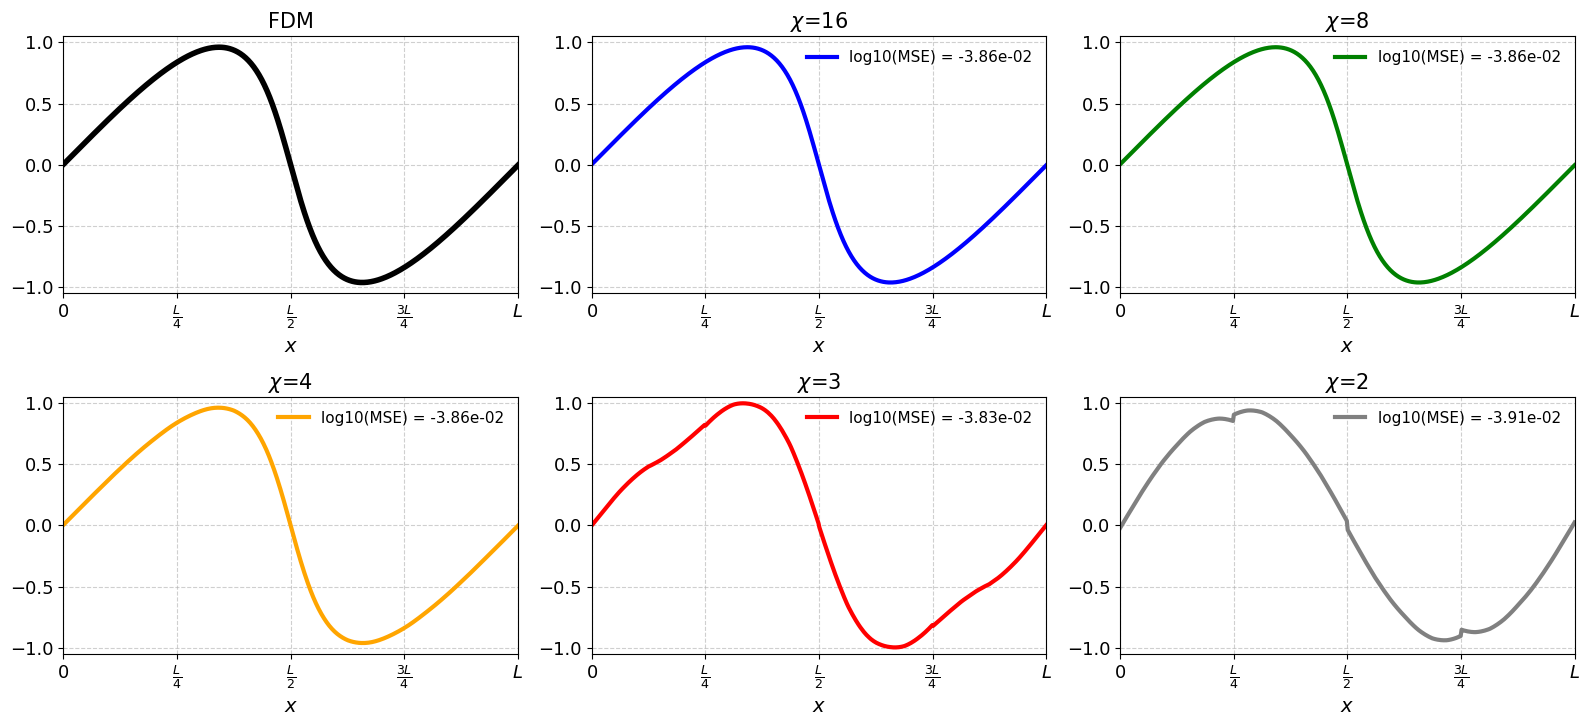

In [ ]:
# ================================
# PLOT – Subplots: FDM vs chi approximations (with MSE)
# ================================
colors = ['black', 'blue', 'green', 'orange', 'red', 'gray']
labels = ['FDM'] + [f'$\chi$={chi}' for chi in chi_values]

# --- Spatial ticks and labels ---
tick_positions = np.linspace(0, 1, 5)
tick_labels = [r"$0$", r"$\frac{L}{4}$", r"$\frac{L}{2}$", r"$\frac{3L}{4}$", r"$L$"]
y_ticks = np.linspace(-1, 1, 5)

# --- Create 2x3 subplots ---
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

# --- Subplot 0: Reference FDM ---
axes[0].plot(x, u, lw=4, color=colors[0])
axes[0].set_title(labels[0], fontsize=15)

# --- Subplots 1–5: chi approximations with MSE in legend ---
for i, (u_approx, label, color) in enumerate(zip(results, labels[1:], colors[1:]), start=1):
    mse = np.mean((u_approx - u) ** 2)
    axes[i].plot(x, u_approx, lw=3, color=color)
    axes[i].set_title(label, fontsize=15)
    axes[i].legend([f"log10(MSE) = {np.log10(mse):.2e}"], loc='upper right', fontsize=11, frameon=False)

# --- Format all subplots ---
for ax in axes[:len(results)+1]:
    ax.set_xlim(0, 1)
    ax.set_ylim(-1.05, 1.05)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, fontsize=13)
    ax.set_yticks(y_ticks)
    ax.tick_params(labelsize=13)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlabel(r'$x$', fontsize=14)
    #ax.set_ylabel(r'$u(x, T)$', fontsize=14)

# --- Hide extra subplot if any ---
if len(axes) > len(results) + 1:
    for j in range(len(results) + 1, len(axes)):
        fig.delaxes(axes[j])

# --- Layout and show ---
#plt.suptitle("Final Velocity Field – Viscous Burgers Equation (1D)", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

